# Resim İşleme

Resim işleme genellikle 2 boyutlu ya da 3 boyutlu (3. boyut renkler olacak şekilde, RGB) sinyallerin matematiksel olarak işlenmesidir. Bu çalışmada Google Street View fotoğraflarından karakter tanıma çalışması gerçekleştireceğiz.


## Fotoğraf
Bir pixel Red, Green, Blue değerlerinden oluşur. Renkler 0 ile 255 arasında bir tamsayı ya da 0 ile 1 arasındaki bir sayıdan oluşur (RGB, $256 \times 256 \times 256$ = 16777216 renk). $w*h$ boyutundaki bir fotoğraf bu boyutlardaki 3 matristen oluşur. 

Bu çalışmada scikit-image paketini kullanacağız. Resimleri okumak ve yazdırmak için **imread** ve **imshow** fonksiyonlarını kullanabiliriz. 

# Karakter Tanıma

Kaggle, Introduction to Julia adlı tutorialdaki veri seti ile çalışacağız. Bu veri setindeki fotoğraflar işlenmiş oldukları için aynı çözünürlüğe sahipler ($20 \times 20 = 400$ piksel). Resimleri siyah-beyaz olarak okutalım ve $1 \times 400$ şeklinde yeniden şekillendirelim.

Aşağıdaki fonksiyon aşağıdaki parametreleri alarak okuma işlemini gerçekleştiriyor: 
* Ana klasörün yolu
* Alt klasörün adı (train, test)
* Etiketler
* Resim boyutu

Elimizde test etiketleri olmadığı için yaptığınız tahminleri kaggle üzerinden değerlendirebilirsiniz. Bu amaçla trainLabels.csv ve sampleSubmission.csv dosyalarını kullanıyoruz.

In [1]:
#Paketleri yükleyelim
%matplotlib inline

import pandas as pd 
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

"""
Input: Folder names (For train, test data sets)
Output: Dataframes containing pictures as vectors
"""
"""
Veriyi okumak için bir fonksiyon
Path, klasör, resim büyüklüğü ve etiketleri alıp resimlerden oluşan bir matris döndürüyor.
"""
def read_data(typeData, labelsInfo, imageSize, path):
    #Intialize x  matrix
    x = np.zeros((labelsInfo.shape[0], imageSize))
    for (index, idImage) in enumerate(labelsInfo["ID"]):
    #Read image file
        nameFile = "{0}/{1}/{2}.Bmp".format(path, typeData, idImage)
        img = imread(nameFile, as_grey=True)
        img = np.reshape(img, (1, imageSize))
        if img.max() > 1:
            img = img/255.0
        #img = normalize(img)
        #img = np.reshape(img, (20,20))
        #img1 = np.gradient(img)
        #img1 = np.abs(img1[0]) + np.abs(img1[1])
        #[index, :] = normalize((np.reshape(img, (1, imageSize)) >=0.5))
        x[index, :] = np.reshape(img, (1, imageSize))
        
    return x


In [2]:
imageSize = 400 # 20 x 20 pixels

# Klasörelerin olduğu yol
path = 'D:\\Dropbox\\GitHub\\DA515\\YOYO\\Güdümlü Öğrenme'

# Dosya adları ve etiketler için
labelsInfoTrain = pd.read_csv("trainLabels.csv")

# Train veri setini okutuyoruz
xTrain = read_data("trainResized", labelsInfoTrain, imageSize, path)

# Kaggle'a sonuçları yollamak için bu dosyanın formatını kullanabilirsiniz.
labelsInfoTest = pd.read_csv("sampleSubmission.csv")

# Test veri setini okutuyoruz
xTest = read_data("testResized", labelsInfoTest, imageSize, path)

print(labelsInfoTrain.head())

   ID Class
0   1     n
1   2     8
2   3     T
3   4     I
4   5     R


'trainResized/3.Bmp' dosyasını renkli ve siyah-beyaz olarak çizdirelim. Siyah-beyazı bir de renklerini ters çevirerek çizdirelim. 

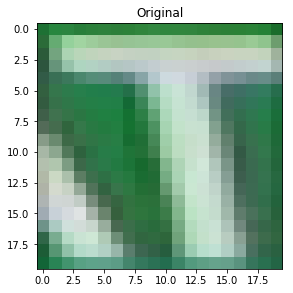

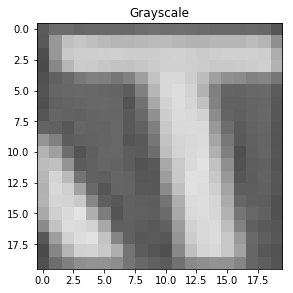

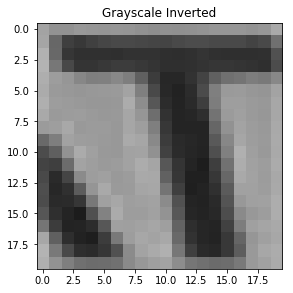

In [3]:
img = imread('trainResized/3.Bmp', as_grey = False)
imshow(img)
plt.title('Original')
plt.show()


img = imread('trainResized/3.Bmp', as_grey=True)
imshow(img)
plt.title('Grayscale')
plt.show()

img = 1- img
imshow(img)
plt.title('Grayscale Inverted')
plt.show()

Etiketleri karakterden ASCII değerine dönüştürmek için **map** fonksiyonunu kullanalım.

In [4]:
"""
In order to convert a label to an integer, we use ascii codes. map(ord, ....) converts characters 
to their values from ascii conversion table, and map(chr, ....) converts an integer to corresponging
character.
"""
yTrain=[]
for i in range(len(labelsInfoTrain)):
    yTrain.append(ord(labelsInfoTrain["Class"].iloc[i]))


print(np.shape(xTrain))
print(np.shape(yTrain))


(6283, 400)
(6283,)


# Tahmin

Bu çalışmada Random Forest Classifier algoritmasını kullanacağız. Resim işleme alanında sinir ağları daha yaygın kullanılsa da bizim amacımız veri üzerinden modeli iyileştirmek olacak. Karar ağacı sayısını 100 olarak belirledik.

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Tahmin modelini kuralım.
rf = RandomForestClassifier(n_estimators = 100,verbose=1)
rf.fit(xTrain,yTrain)
y_pred = rf.predict(xTest)

y_pred2 = []
for i in range(len(y_pred)):
    y_pred2.append(chr(y_pred[i]))

labelsInfoTest['Class'] = y_pred2

labelsInfoTest.to_csv('Results_random_forest.csv', index=False)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Değerlendirmeyi doğruluk üzerinden yapıyoruz.

Random Forest Classifier: 0.46

Bu aşamada Random Forest yönteminin parametreleriyle oynamadan veri setini zenginleştirerek sonuçları iyileştirmeye çalışacağız. İlk başta önemli özniteliklere (piksellere) bakalım)

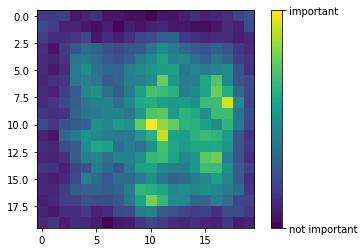

In [6]:
features = rf.feature_importances_
features = np.reshape(features,(20,20))
plt.imshow(features, interpolation='none')
cb = plt.colorbar()
cb.set_ticks([rf.feature_importances_.min(), rf.feature_importances_.max()]) 
cb.set_ticklabels(['not important', 'important'])  # put text labels on them
plt.show()


# İyileştirmeler (Data Augmentation)

Bir sonraki aşamada yapacağımız resimlerin tersini de veri setine eklemek olacak. Bu sayede koyu arka plan üzerine açık renkle ya da açık arka plan üzerine koyu renkle yazılmış resimler oluşturarak daha iyi bir öğrenme sağlamayı hedefliyoruz. 


In [7]:
#Veri setlerini zenginleştirelim
xTrain = np.append(xTrain, 1- xTrain, axis = 0)
yTrain = np.append(yTrain, yTrain, axis = 0)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


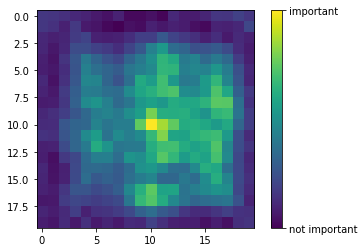

In [8]:
rf = RandomForestClassifier(n_estimators = 100,verbose=1)
rf.fit(xTrain,yTrain)
y_pred = rf.predict(xTest)
y_pred2 = []
for i in range(len(y_pred)):
    y_pred2.append(chr(y_pred[i]))

labelsInfoTest['Class'] = y_pred2
labelsInfoTest.to_csv('Results_random_forest_negative.csv', index=False)

features = rf.feature_importances_
features = np.reshape(features,(20,20))
plt.imshow(features, interpolation='none')
cb = plt.colorbar()
cb.set_ticks([rf.feature_importances_.min(), rf.feature_importances_.max()])  
cb.set_ticklabels(['not important', 'important'])  # put text labels on them
plt.show()

Doğruluk değeri 0.48'e çıktı. 

Uygulayabileceğimiz bir diğer yöntem de scaling. Bu yöntemde her resmi 0 ile 1 arasındaki değerlerden oluşacak şekilde ölçeklendiriyoruz. 'trainResized/3.Bmp' üzerinden bunun etkisine bakalım.

In [9]:
"""
Used in order to normalize data:
Input: Grayscale image
Output: Same image converted to range white and black (0-1)
"""
def scale(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    minval = arr.min()
    maxval = arr.max()
    if minval != maxval:
        arr -= minval
        arr *= (255.0/(maxval-minval))
    return arr/255


Minimum value of a pixel 0.293496862745
Maximum value of a pixel 0.886862745098


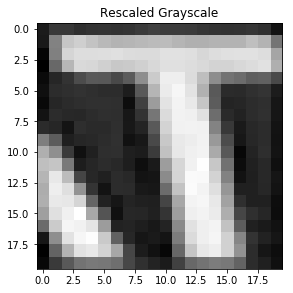

Minimum value of a pixel 0.0
Maximum value of a pixel 1.0


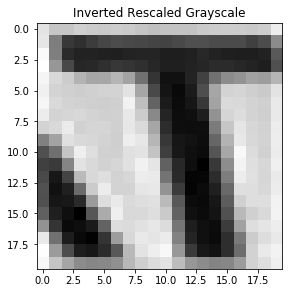

In [10]:
img = imread('trainResized/3.Bmp', as_grey=True)
print('Minimum value of a pixel ' + str(img.min()))
print('Maximum value of a pixel ' + str(img.max()))

img = scale(img)
#To avoid numerical instabilities
img[img >= 1] = 1
img[img <= 0] = 0
imshow(img)
plt.title('Rescaled Grayscale')
plt.show()
print('Minimum value of a pixel ' + str(img.min()))
print('Maximum value of a pixel ' + str(img.max()))

img = 1-img
imshow(img)
plt.title('Inverted Rescaled Grayscale')
plt.show()


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   55.4s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


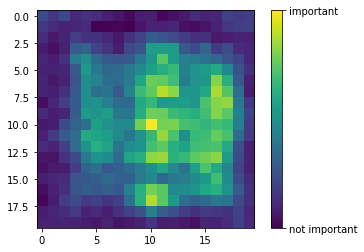

In [11]:
#Veri setlerini ölçeklendirelim
for i in range(len(xTrain)):
    xTrain[i,:] = scale(xTrain[i,:])

for i in range(len(xTest)):
    xTest[i,:] = scale(xTest[i,:])
                     
xTrain[xTrain > 1] = 1
xTrain[xTrain < 0] = 0
xTest[xTest > 1] = 1
xTest[xTest < 0] = 0

rf = RandomForestClassifier(n_estimators = 100,verbose=1)
rf.fit(xTrain,yTrain)
y_pred = rf.predict(xTest)
y_pred2 = []
for i in range(len(y_pred)):
    y_pred2.append(chr(y_pred[i]))

labelsInfoTest['Class'] = y_pred2
labelsInfoTest.to_csv('Results_random_forest_negative_rescaled.csv', index=False)


features = rf.feature_importances_
features = np.reshape(features,(20,20))
plt.imshow(features, interpolation='none')
cb = plt.colorbar()
cb.set_ticks([rf.feature_importances_.min(), rf.feature_importances_.max()])  # force there to be only 3 ticks
cb.set_ticklabels(['not important', 'important'])  # put text labels on them
plt.show()

Artık doğruluk değeri 0.54. Başladığız yere göre ilerleme kaydetsek de yapabileceğimiz başka şeyler de var. Resimler için eşik değerler belirleyerek resimleri tamamen siyah ve beyaz piksellerden oluşacak şekilde düzenleyelim. 'trainResized/3.Bmp' üzerinde bunun etkisine bakalım.

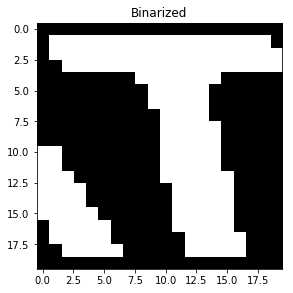

In [12]:
img = imread('trainResized/3.Bmp', as_grey=True)
img = scale(img)
img = (img >= 0.5) *1.0
imshow(img)
plt.title('Binarized')
plt.show()

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


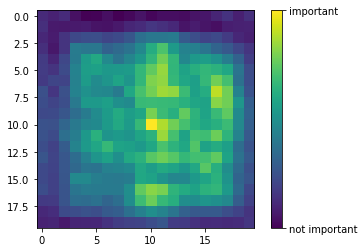

In [13]:
#Veri setlerini ikili hale çevirelim
xTrain = (xTrain >= 0.5)*1
xTest = (xTest >= 0.5)*1

rf = RandomForestClassifier(n_estimators = 100, verbose = 1)

rf.fit(xTrain,yTrain)
y_pred = rf.predict(xTest)
y_pred2 = []
for i in range(len(y_pred)):
    y_pred2.append(chr(y_pred[i]))

labelsInfoTest['Class'] = y_pred2
labelsInfoTest.to_csv('Results_random_forest_negative_rescaled_binary.csv', index=False)

features = rf.feature_importances_

features = np.reshape(features,(20,20))

plt.imshow(features, interpolation='none')
cb = plt.colorbar()
cb.set_ticks([rf.feature_importances_.min(), rf.feature_importances_.max()])  # force there to be only 3 ticks
cb.set_ticklabels(['not important', 'important'])  # put text labels on them
plt.show()

Artık doğruluk değeri 0.61. Neredeyse 15%'lik bir iyileşme kaydettik. Data augmentation için yapılabilecek başka adımlar da var. Resimleri az miktarda çevirerek ya da kaydırarak veriyi zenginleştirip sonuçları iyileştirmek mümkün.

# Sources

http://scikit-image.org/

https://www.kaggle.com/c/street-view-getting-started-with-julia

http://www.cs.uregina.ca/Links/class-info/325/PythonPictures/

https://en.wikipedia.org/wiki/Edge_detection

Histogram of Oriented Gradients
http://www.comp.nus.edu.sg/~tians/papers/ICPR2014_Convolution-CoHOG_Su.pdf
